# PCAによる次元圧縮のJulia実装
---

IrisデータセットのPCAによる次元圧縮をやる．
PCAの定式化は須山ベイズ5章のものと同じ．ただし，推論はギプスサンプリングで行う．

In [1]:
using Plots
using RDatasets
using Setfield
using ProgressBars

using Distributions
using LinearAlgebra
using PDMats
using Combinatorics

Irisデータセットの読み込みと可視化

In [2]:
iris = dataset("datasets", "iris");
first(iris, 5)

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
,Float64,Float64,Float64,Float64,Categorical…
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa


In [3]:
Y = Matrix(iris)[:, 1:4];
labels = Matrix(iris)[:, 5];

name_map = Dict([(k, i) for (i, k) in enumerate(unique(labels))])
labels = [name_map[label] for label in labels];

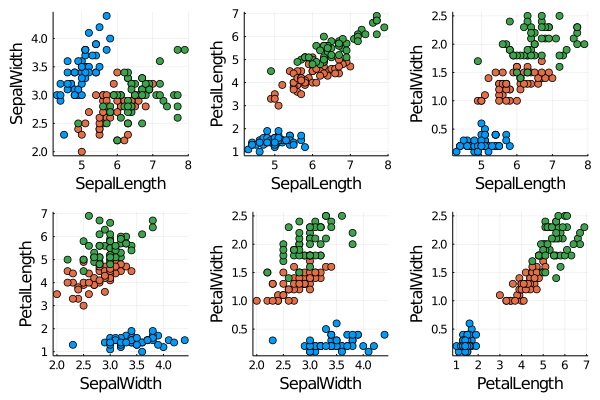

In [4]:
plt_list = []
for ((xidx, xlabel), (yidx, ylabel)) in combinations(collect(enumerate(names(iris)[1:4])), 2)
    plt = scatter(
        iris[:, xidx], iris[:, yidx], 
        color=labels,
        xlabel=string(xlabel), ylabel=string(ylabel)
    )
    push!(plt_list, plt)
end

plot(
    plt_list...,
    legend=:none
)

# PCAの実装

PCAを表現する構造体

In [5]:
struct PCA
    D::Int64
    M::Int64
    W::Matrix{Float64}
    μ::Vector{Float64}
    σ2_y::Float64
    Σ_W::Matrix{Float64}
    Σ_μ::Matrix{Float64}
end

In [6]:
function create_PCA(D::Int64, M::Int64, σ2_y::Float64, Σ_W::Matrix{Float64}, Σ_μ::Matrix{Float64})
    W = zeros(M, D)
    for d in 1:D
        W[:, d] = rand(MvNormal(zeros(M), Σ_W))
    end
    
    μ = rand(MvNormal(zeros(D), Σ_μ))
    
    return PCA(D, M, W, μ, σ2_y, Σ_W, Σ_μ)
end

create_PCA (generic function with 1 method)

ハイパーパラメタの定義とPCAの初期化

In [7]:
D = 4
M = 2
σ2_y = 0.01
pca = create_PCA(D, M, σ2_y, Matrix{Float64}(I, M, M), Matrix{Float64}(I, D, D))

PCA(4, 2, [-0.3949055076385098 1.1961525501843704 -0.15471872720418894 2.657110789881289; -2.1456846310424273 -0.8444664513277556 -0.15113684980225908 1.3537201873482476], [-1.165650753631122, -0.38601133777394747, 0.5575951693782492, 1.043946428716144], 0.01, [1.0 0.0; 0.0 1.0], [1.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0])

Irisデータセットの各行を標準化する．

In [8]:
Y = Matrix(iris)[:, 1:4];
Y = (Y .- mean(Y, dims=1)) ./ std(Y, dims=1);

潜在変数を事前分布からサンプリングする

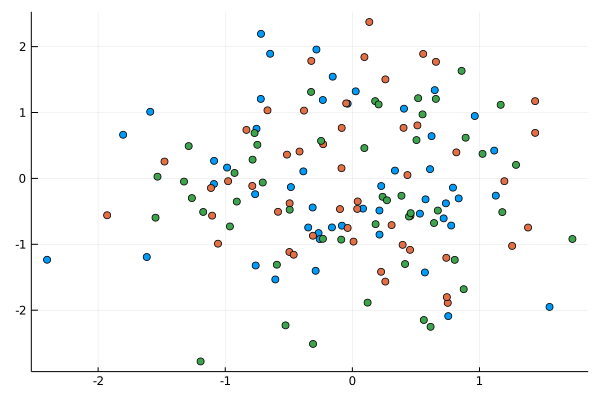

In [9]:
N = size(Y, 1)
X = zeros(N, pca.M);
size(X)

for n in 1:N
    X[n, :] = rand(MvNormal(zeros(pca.M), Matrix{Float64}(I, pca.M, pca.M)))
end
scatter(X[:, 1], X[:, 2], legend=:none, color=labels)

# PCAのギプスサンプリングの実装

サンプリングの式は以下の通り：

* 潜在変数$\mathbf X = \{\mathbf x_n\}_{n=1}^N$のサンプリング
\begin{align}
    p(\mathbf X | \mathbf W, \boldsymbol\mu, \mathbf Y)
    &= \prod_{n=1}^N \mathcal N(\mathbf x_n | \hat{\mathbf m}_{\mathbf x_n}, \hat{\boldsymbol\Sigma})\\
    \hat{\boldsymbol\Sigma}^{-1}
    &= \mathbf I_M + \frac{1}{\sigma^2_y}\mathbf W\mathbf W^\top \\
    \hat{\mathbf m}_{\mathbf x_n}
    &= \hat{\boldsymbol\Sigma}\left\{\frac{1}{\sigma^2_y}\mathbf W(\mathbf y_n - \boldsymbol\mu)\right\}
\end{align}
* 行列パラメタ$\mathbf W$のサンプリング
\begin{align}
    p(\mathbf W | \boldsymbol\mu, \mathbf X, \mathbf Y)
    &= \prod_{d=1}^D \mathcal N(\mathbf W_{:,d} | \hat{\mathbf m}_{\mathbf W_d}, \hat{\boldsymbol\Sigma}_{\mathbf W})\\
    \hat{\boldsymbol \Sigma}^{-1}_{\mathbf W}
    &= \boldsymbol\Sigma^{-1}_{\mathbf W} + \frac{1}{\sigma^2_y}\left\langle\mathbf x\mathbf x^\top\right\rangle\\
    \hat{\mathbf m}_{\mathbf W_d}
    &= \hat{\boldsymbol\Sigma}_{\mathbf W}
    \left(\frac{1}{\sigma^2_y}\sum_{n=1}^N(y_{n,d}-\mu_d)\mathbf x_n\right)
\end{align}
ここで，
$\langle\mathbf x\mathbf x^\top\rangle = \sum_n \mathbf x_n\mathbf x_n^\top$である．
* バイアスパラメタ$\boldsymbol\mu$のサンプリング
\begin{align}
    p(\boldsymbol\mu | \mathbf W, \mathbf X, \mathbf Y)
    &= \mathcal N(\boldsymbol\mu | \hat{\mathbf m}_{\boldsymbol \mu}, \hat{\boldsymbol \Sigma}_{\boldsymbol \mu}) \\
    \hat{\boldsymbol \Sigma}^{-1}_{\boldsymbol \mu}
    &= \boldsymbol\Sigma^{-1}_{\boldsymbol \mu} + \frac{N}{\sigma^2_y}\mathbf I_D\\
    \hat{\mathbf m}_{\boldsymbol \mu}
    &= \frac{1}{\sigma^2_y}\hat{\boldsymbol \Sigma}_{\boldsymbol \mu}
    \left(\langle\mathbf y\rangle - \mathbf W^\top\langle\mathbf x\rangle\right)
\end{align}
ここで，
$\langle\mathbf y\rangle = \sum_n \mathbf y_n$および
$\langle\mathbf x\rangle = \sum_n \mathbf x_n$である．

In [10]:
function sample_hidden_variables(pca::PCA, Y::Array{Float64})
    X_new = zeros(N, pca.M);

    Λ_post = inv(Matrix{Float64}(I, pca.M, pca.M)) + pca.W * pca.W' ./ pca.σ2_y
    Σ_post = inv(Λ_post)
    Σ_post_pd = PDMat(Symmetric(Σ_post))

    for n in 1:N
        m_post = (Σ_post * pca.W * (Y[n, :] - pca.μ)) ./ pca.σ2_y
        X_new[n, :] = rand(MvNormal(m_post, Σ_post_pd))
    end
    
    return X_new
end

sample_hidden_variables (generic function with 1 method)

In [11]:
function sample_matrix_parameter(pca::PCA, Y::Array{Float64}, X::Array{Float64})
    W_new = zeros(pca.M, pca.D)

    Λ_W_post = inv(pca.Σ_W) + X' * X ./ pca.σ2_y
    Σ_W_post = inv(Λ_W_post)
    Σ_W_post_pd = PDMat(Symmetric(Σ_W_post))

    for d in 1:pca.D
        m_W_post = Σ_W_post * sum((Y[:, d] .- pca.μ[d]) .* X, dims=1)' ./ pca.σ2_y
        m_W_post = m_W_post[:] # Convert "2x1 Array" to "2-element Array"
        W_new[:, d] = rand(MvNormal(m_W_post, Σ_W_post_pd))
    end
    
    pca_new = @set pca.W = W_new
    return pca_new
end

sample_matrix_parameter (generic function with 1 method)

In [12]:
function sample_bias_parameter(pca::PCA, Y::Array{Float64}, X::Array{Float64})
    Λ_μ_post = inv(pca.Σ_μ) .+ (N / pca.σ2_y .* Matrix{Float64}(I, pca.D, pca.D))
    Σ_μ_post = inv(Λ_μ_post)
    m_μ_post = Σ_μ_post * (sum(Y, dims=1)' - pca.W' * sum(X, dims=1)')
    
    μ_new = rand(MvNormal(m_μ_post[:], PDMat(Symmetric(Σ_μ_post))))
    
    pca_new = @set pca.μ = μ_new
    return pca_new
end

sample_bias_parameter (generic function with 1 method)

# ギプスサンプリングの実行

事後確率を計算する関数

In [13]:
function compute_log_likelihood(pca::PCA, Y::Array{Float64}, X::Array{Float64})
    
    log_lik = 0.0

    for d in 1:pca.D
        log_lik += logpdf(MvNormal(zeros(pca.M), pca.Σ_W), pca.W[:, d])
    end

    log_lik += logpdf(MvNormal(zeros(pca.D), pca.Σ_μ), pca.μ)

    m_xn = pca.W' * X' .+ pca.μ

    for n in 1:N
        log_lik += logpdf(MvNormal(m_xn[:, n], pca.σ2_y * Matrix{Float64}(I, pca.D, pca.D)), Y[n, :])
        log_lik += logpdf(MvNormal(zeros(pca.M), Matrix{Float64}(I, pca.M, pca.M)), X[n, :])
    end
    
    return log_lik
end

compute_log_likelihood (generic function with 1 method)

In [14]:
# 対数同時確率を最大にするパラメタと潜在変数，そのときの対数事後確率を保存する
pca_max = deepcopy(pca)
X_max = copy(X)
loglik_max = compute_log_likelihood(pca, Y, X)

-141537.14990416254

In [15]:
loglik_list = Array{Float64, 1}()

0-element Array{Float64,1}

In [16]:
anim = Animation()

# 初期状態のプロット
plt = scatter(
    X[:, 1], X[:, 2],
    legend=:none, color=labels,
    xlim=(-2.0, 2.0), ylim=(-1.5, 1.5)
)
title!("Iteration: 0")
frame(anim, plt)

for iter in tqdm(1:20)
    X = sample_hidden_variables(pca, Y);
    pca = sample_matrix_parameter(pca, Y, X);
    pca = sample_bias_parameter(pca, Y, X);
    
    loglik = compute_log_likelihood(pca, Y, X)
    
    if loglik > loglik_max
        pca_max = deepcopy(pca)
        X_max = copy(X)
        loglik_max = loglik
    end
    
    push!(loglik_list, loglik)
    
    plt = plot()
    scatter!(
        X[:, 1], X[:, 2],
        legend=:none, color=labels,
        xlim=(-3.0, 3.0), ylim=(-3.0, 3.0)
    )
    title!("Iteration: $iter")
    frame(anim, plt)
end

gif(anim, "gs_pca.gif", fps=2);

100.0%┣██████████████████████████████████████████┫ 20/20 [00:06<00:00, 3.2 it/s]2/20 [00:05<01:33, 0.2 it/s]5/20 [00:05<00:20, 0.8 it/s]18/20 [00:06<00:01, 2.9 it/s]


┌ Info: Saved animation to 
│   fn = C:\Users\chikuwa\workspace\julia-work\gs_pca.gif
└ @ Plots C:\Users\chikuwa\.julia\packages\Plots\ZRCUN\src\animation.jl:102


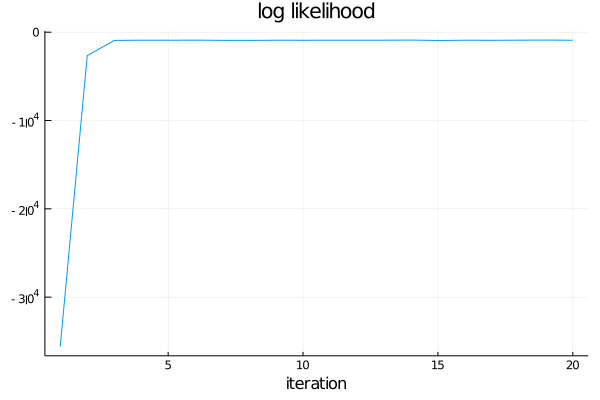

GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error


In [17]:
plot(loglik_list, legend=:none, title="log likelihood", xlabel="iteration")

Gibbsサンプリングの過程の可視化

![gs_pca](gs_pca.gif)

結果

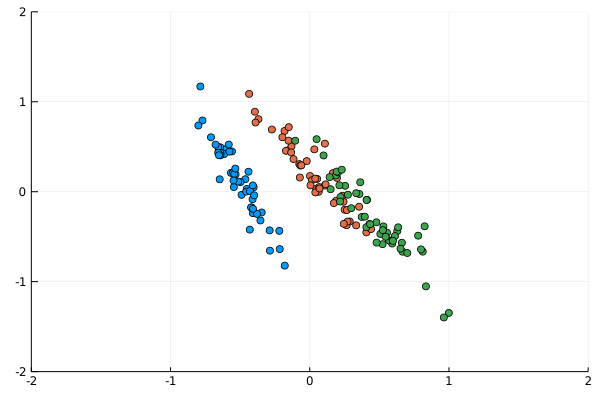

In [18]:
scatter(
    X_max[:, 1], X_max[:, 2],
    legend=:none, color=labels,
    xlim=(-2.0, 2.0), ylim=(-2.0, 2.0)
)